# Amazon Beauty Dataset - Exploratory Data Analysis


### Interaction Data Analysis

1. **Basic Dataset Statistics** - Dataset overview, key metrics, sparsity/density calculations, and missing value checks
2. **User Analysis** - User interaction patterns, distributions, user segmentation (inactive/light/medium/heavy/power users), and top active users
3. **Item Analysis** - Item popularity distributions, long-tail effects, item segmentation, and top popular items
4. **Rating Analysis** - Rating distributions, bias analysis (positive/negative/neutral), feedback type (implicit vs explicit), and statistical measures
5. **Temporal Analysis** - Time-based patterns, interactions over time (monthly aggregation), and temporal trends
6. **Data Quality Checks** - Duplicate detection, missing value analysis, data type consistency, ID mapping status, outlier detection (users and items), and preprocessing filter effects
7. **Train/Valid/Test Split Analysis** - Split sizes, user/item coverage across splits, overlap analysis, and cold-start analysis (new users/items in validation and test sets)

### Item Metadata Analysis

8. **Item Dataset Analysis** - Analysis of item features and metadata:
   - **8.1 Load Item Data** - Loading and basic inspection of item metadata
   - **8.2 Missing Value Analysis** - Missing data patterns across all item features
   - **8.3 Item-Interaction Alignment** - Verification of alignment between items in interactions and item metadata
   - **8.4 Numerical Features Analysis** - Price and sales rank distributions, statistics, and visualizations
   - **8.5 Categorical Features Analysis** - Sales type and brand distributions, brand concentration analysis
   - **8.6 Category Hierarchy Analysis** - Hierarchical category structure, depth analysis, and category distributions at each level (primary/secondary/tertiary)
   - **8.7 Data Quality Checks** - Duplicate item IDs, feature completeness, and outlier detection in numerical features
   - **8.8 Feature Coverage Summary** - Feature availability across train/valid/test splits 
## Model Selection:

- **High Sparsity** → Matrix factorization (BPR, ALS) or deep models (NCF, NeuMF)
- **Strong Temporal Patterns** → Sequential models (SASRec, GRU4Rec)
- **Long-tail Distribution** → Sampling strategies, popularity bias correction
- **Rich Item Metadata** → Content-based or hybrid approaches (DeepFM, Wide&Deep)
- **Cold-start Challenges** → Use item features for new items in validation/test sets



## Setup: Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
import warnings

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

print("Libraries imported successfully")


Libraries imported successfully


## Data Loading


In [2]:
# Load the interaction data
data_file = 'dataset/amazon-beauty/amazon-beauty.inter'
df = pd.read_csv(data_file, sep='\t')

print(f"Dataset loaded: {data_file}")
print(f"Shape: {df.shape}")
print(f"\nColumn names: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset loaded: dataset/amazon-beauty/amazon-beauty.inter
Shape: (2023070, 4)

Column names: ['user_id:token', 'item_id:token', 'rating:float', 'timestamp:float']

First few rows:


,user_id:token,item_id:token,rating:float,timestamp:float
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
# Data types and basic info
print("Dataset Info:")
print("=" * 70)
df.info()
print("\n" + "=" * 70)
print("\nBasic Statistics:")
df.describe()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023070 entries, 0 to 2023069
Data columns (total 4 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id:token    object 
 1   item_id:token    object 
 2   rating:float     float64
 3   timestamp:float  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


Basic Statistics:


,rating:float,timestamp:float
count,2.0231e+06,2.0231e+06
mean,4.1490e+00,1.3604e+09
std,1.3115e+00,4.6119e+07
min,1.0000e+00,9.0876e+08
25%,4.0000e+00,1.3503e+09
50%,5.0000e+00,1.3728e+09
75%,5.0000e+00,1.3915e+09
max,5.0000e+00,1.4061e+09


## 1. Basic Dataset Statistics

Key metrics to understand the dataset scale and characteristics.


In [4]:
# Calculate key statistics
n_interactions = len(df)
n_users = df['user_id:token'].nunique()
n_items = df['item_id:token'].nunique()

# Sparsity calculation
sparsity = 1 - (n_interactions / (n_users * n_items))

# Density
density = n_interactions / (n_users * n_items)

# Ratings stats (if rating column exists)
if 'rating:float' in df.columns:
    avg_rating = df['rating:float'].mean()
    median_rating = df['rating:float'].median()
    std_rating = df['rating:float'].std()
else:
    avg_rating = median_rating = std_rating = None

# Interactions per user/item
interactions_per_user = df.groupby('user_id:token').size()
interactions_per_item = df.groupby('item_id:token').size()

# Create summary table
stats_summary = pd.DataFrame({
    'Metric': [
        'Total Interactions',
        'Unique Users',
        'Unique Items',
        'Sparsity (%)',
        'Density',
        'Avg Interactions per User',
        'Avg Interactions per Item',
        'Median Interactions per User',
        'Median Interactions per Item',
        'Max Interactions per User',
        'Max Interactions per Item',
        'Min Interactions per User',
        'Min Interactions per Item',
        'Avg Rating' if avg_rating else None,
        'Median Rating' if median_rating else None,
        'Std Rating' if std_rating else None,
    ],
    'Value': [
        f'{n_interactions:,}',
        f'{n_users:,}',
        f'{n_items:,}',
        f'{sparsity * 100:.6f}%',
        f'{density:.8f}',
        f'{interactions_per_user.mean():.2f}',
        f'{interactions_per_item.mean():.2f}',
        f'{interactions_per_user.median():.0f}',
        f'{interactions_per_item.median():.0f}',
        f'{interactions_per_user.max():,}',
        f'{interactions_per_item.max():,}',
        f'{interactions_per_user.min()}',
        f'{interactions_per_item.min()}',
        f'{avg_rating:.4f}' if avg_rating else None,
        f'{median_rating:.1f}' if median_rating else None,
        f'{std_rating:.4f}' if std_rating else None,
    ]
})

# Remove None rows
stats_summary = stats_summary.dropna()

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(stats_summary.to_string(index=False))
print("=" * 70)


DATASET OVERVIEW
                      Metric      Value
          Total Interactions  2,023,070
                Unique Users  1,210,271
                Unique Items    249,274
                Sparsity (%) 99.999329%
                     Density 0.00000671
   Avg Interactions per User       1.67
   Avg Interactions per Item       8.12
Median Interactions per User          1
Median Interactions per Item          2
   Max Interactions per User        389
   Max Interactions per Item      7,533
   Min Interactions per User          1
   Min Interactions per Item          1
                  Avg Rating     4.1490
               Median Rating        5.0
                  Std Rating     1.3115


In [5]:
# Check for missing values
print("Missing Values Check:")
print("=" * 70)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Percentage': missing_pct.values
})
print(missing_df.to_string(index=False))
print("=" * 70)

# Check for duplicate interactions
duplicates = df.duplicated(subset=['user_id:token', 'item_id:token']).sum()
print(f"\nDuplicate user-item pairs: {duplicates:,} ({duplicates/len(df)*100:.4f}%)")


Missing Values Check:
         Column  Missing Count  Percentage
  user_id:token              0         0.0
  item_id:token              0         0.0
   rating:float              0         0.0
timestamp:float              0         0.0

Duplicate user-item pairs: 0 (0.0000%)


## 2. User Analysis

Understanding user behavior patterns and interaction distributions.


In [6]:
# User interaction statistics
user_stats = interactions_per_user.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

print("User Interaction Statistics:")
print("=" * 70)
print(user_stats)
print("=" * 70)

# Identify user segments
print("\nUser Segments:")
print(f"  Inactive users (5 interactions): {(interactions_per_user == 5).sum():,} ({(interactions_per_user == 5).sum()/n_users*100:.2f}%)")
print(f"  Light users (6-10 interactions): {((interactions_per_user > 5) & (interactions_per_user <= 10)).sum():,}")
print(f"  Medium users (11-50 interactions): {((interactions_per_user > 10) & (interactions_per_user <= 50)).sum():,}")
print(f"  Heavy users (51-200 interactions): {((interactions_per_user > 50) & (interactions_per_user <= 200)).sum():,}")
print(f"  Power users (200+ interactions): {(interactions_per_user > 200).sum():,}")

# Top users
print(f"\nTop 10 Most Active Users:")
top_users = interactions_per_user.nlargest(10) # returns the **10 users with the most interactions**, sorted in descending order
for i, (user_id, count) in enumerate(top_users.items(), 1):
    print(f"  {i}. User {user_id}: {count:,} interactions")


User Interaction Statistics:
count    1.2103e+06
mean     1.6716e+00
std      2.5319e+00
min      1.0000e+00
25%      1.0000e+00
50%      1.0000e+00
75%      2.0000e+00
90%      3.0000e+00
95%      4.0000e+00
99%      1.0000e+01
max      3.8900e+02
dtype: float64

User Segments:
  Inactive users (5 interactions): 16,187 (1.34%)
  Light users (6-10 interactions): 25,867
  Medium users (11-50 interactions): 9,976
  Heavy users (51-200 interactions): 331
  Power users (200+ interactions): 13

Top 10 Most Active Users:
  1. User A3KEZLJ59C1JVH: 389 interactions
  2. User A281NPSIMI1C2R: 336 interactions
  3. User A3M174IC0VXOS2: 326 interactions
  4. User A2V5R832QCSOMX: 278 interactions
  5. User A3LJLRIZL38GG3: 276 interactions
  6. User ALQGOMOY1F5X9: 275 interactions
  7. User AKMEY1BSHSDG7: 269 interactions
  8. User A3R9H6OKZHHRJD: 259 interactions
  9. User A1M04H40ZVGWVG: 249 interactions
  10. User A1RRMZKOMZ2M7J: 225 interactions


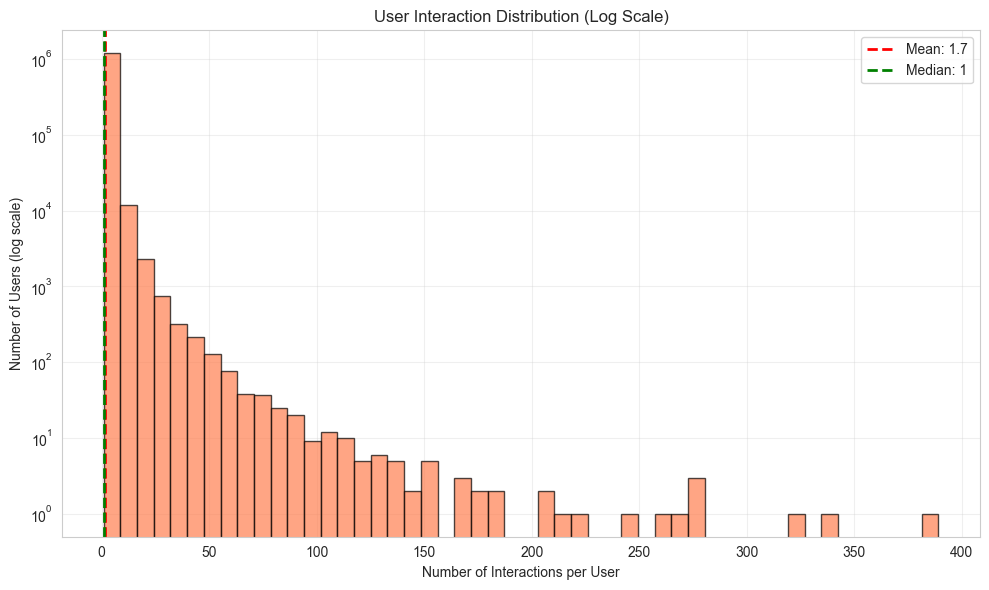


Interpretation: The distribution shows a long-tail pattern.
Skewness: 28.63


In [7]:
# Visualization: User interaction distribution (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Log scale histogram
ax.hist(interactions_per_user, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Number of Interactions per User')
ax.set_ylabel('Number of Users (log scale)')
ax.set_title('User Interaction Distribution (Log Scale)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(interactions_per_user.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {interactions_per_user.mean():.1f}')
ax.axvline(interactions_per_user.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {interactions_per_user.median():.0f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nInterpretation: The distribution shows a {'long-tail' if interactions_per_user.skew() > 1 else 'relatively normal'} pattern.")
print(f"Skewness: {interactions_per_user.skew():.2f}")


## 3. Item Analysis

Understanding item popularity, long-tail effects, and cold-start challenges.


In [8]:
# Item interaction statistics
item_stats = interactions_per_item.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

print("Item Interaction Statistics:")
print("=" * 70)
print(item_stats)
print("=" * 70)

# Identify item segments
print("\nItem Segments:")
print(f"  Cold-start items (5 interactions): {(interactions_per_item == 5).sum():,} ({(interactions_per_item == 5).sum()/n_items*100:.2f}%)")
print(f"  Unpopular items (6-10 interactions): {((interactions_per_item > 5) & (interactions_per_item <= 10)).sum():,}")
print(f"  Moderate items (11-50 interactions): {((interactions_per_item > 10) & (interactions_per_item <= 50)).sum():,}")
print(f"  Popular items (51-200 interactions): {((interactions_per_item > 50) & (interactions_per_item <= 200)).sum():,}")
print(f"  Blockbuster items (200+ interactions): {(interactions_per_item > 200).sum():,}")

# Top items
print(f"\nTop 10 Most Popular Items:")
top_items = interactions_per_item.nlargest(10)
for i, (item_id, count) in enumerate(top_items.items(), 1):
    print(f"  {i}. Item {item_id}: {count:,} interactions")


Item Interaction Statistics:
count    249274.0000
mean          8.1158
std          36.0641
min           1.0000
25%           1.0000
50%           2.0000
75%           5.0000
90%          15.0000
95%          30.0000
99%         106.0000
max        7533.0000
dtype: float64

Item Segments:
  Cold-start items (5 interactions): 9,623 (3.86%)
  Unpopular items (6-10 interactions): 23,843
  Moderate items (11-50 interactions): 27,082
  Popular items (51-200 interactions): 5,869
  Blockbuster items (200+ interactions): 928

Top 10 Most Popular Items:
  1. Item B001MA0QY2: 7,533 interactions
  2. Item B0009V1YR8: 2,869 interactions
  3. Item B0043OYFKU: 2,477 interactions
  4. Item B0000YUXI0: 2,143 interactions
  5. Item B003V265QW: 2,088 interactions
  6. Item B000ZMBSPE: 2,041 interactions
  7. Item B003BQ6QXK: 1,918 interactions
  8. Item B004OHQR1Q: 1,885 interactions
  9. Item B00121UVU0: 1,838 interactions
  10. Item B000FS05VG: 1,589 interactions


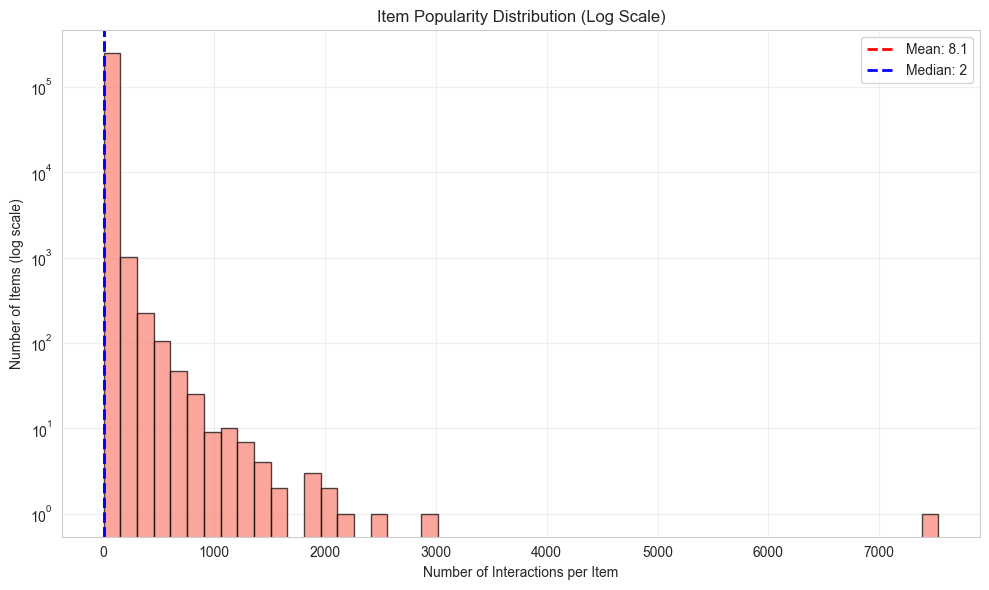


Interpretation: The distribution shows a strong long-tail pattern.
Skewness: 54.18


In [9]:
# Visualization: Item popularity distribution (log scale)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Log scale histogram
ax.hist(interactions_per_item, bins=50, edgecolor='black', alpha=0.7, color='salmon')
ax.set_xlabel('Number of Interactions per Item')
ax.set_ylabel('Number of Items (log scale)')
ax.set_title('Item Popularity Distribution (Log Scale)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)
ax.axvline(interactions_per_item.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {interactions_per_item.mean():.1f}')
ax.axvline(interactions_per_item.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {interactions_per_item.median():.0f}')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nInterpretation: The distribution shows a {'strong long-tail' if interactions_per_item.skew() > 2 else 'long-tail'} pattern.")
print(f"Skewness: {interactions_per_item.skew():.2f}")


## 4. Rating Analysis

Analyzing rating distributions, bias, and feedback characteristics.


In [10]:
# Rating distribution
if 'rating:float' in df.columns:
    rating_counts = df['rating:float'].value_counts().sort_index()
    
    print("Rating Distribution:")
    print("=" * 70)
    for rating, count in rating_counts.items():
        pct = (count / len(df)) * 100
        bar = '█' * int(pct / 2)
        print(f"  {rating}: {count:>8,} ({pct:>5.2f}%) {bar}")
    print("=" * 70)
    
    print(f"\nRating Statistics:")
    print(f"  Mean: {df['rating:float'].mean():.4f}")
    print(f"  Median: {df['rating:float'].median():.1f}")
    print(f"  Mode: {df['rating:float'].mode().values[0]:.1f}")
    print(f"  Std Dev: {df['rating:float'].std():.4f}")
    print(f"  Skewness: {df['rating:float'].skew():.4f}")
    print(f"  Kurtosis: {df['rating:float'].kurt():.4f}")
else:
    print("No rating column found in dataset.")


Rating Distribution:
  1.0:  183,784 ( 9.08%) ████
  2.0:  113,034 ( 5.59%) ██
  3.0:  169,791 ( 8.39%) ████
  4.0:  307,740 (15.21%) ███████
  5.0: 1,248,721 (61.72%) ██████████████████████████████

Rating Statistics:
  Mean: 4.1490
  Median: 5.0
  Mode: 5.0
  Std Dev: 1.3115
  Skewness: -1.3914
  Kurtosis: 0.5811


In [11]:
# Rating bias analysis
if 'rating:float' in df.columns:
    # Positive vs negative bias
    positive_ratings = df[df['rating:float'] >= 4].shape[0]
    negative_ratings = df[df['rating:float'] <= 2].shape[0]
    neutral_ratings = df[df['rating:float'] == 3].shape[0]
    
    print(f"\nRating Bias Analysis:")
    print("=" * 70)
    print(f"  Positive ratings (4-5): {positive_ratings:,} ({positive_ratings/len(df)*100:.2f}%)")
    print(f"  Neutral ratings (3): {neutral_ratings:,} ({neutral_ratings/len(df)*100:.2f}%)")
    print(f"  Negative ratings (1-2): {negative_ratings:,} ({negative_ratings/len(df)*100:.2f}%)")
    print(f"\n  Positive/Negative Ratio: {positive_ratings/negative_ratings:.2f}:1" if negative_ratings > 0 else "  No negative ratings")
    
    # Implicit vs Explicit feedback
    if df['rating:float'].max() <= 1:
        print(f"\n  Feedback Type: IMPLICIT (binary 0/1)")
    else:
        print(f"\n  Feedback Type: EXPLICIT (multi-level ratings)")
    
    # Rating distribution skewness interpretation
    skew = df['rating:float'].skew()
    if skew < -0.5:
        print(f"  Distribution: Left-skewed (bias towards higher ratings)")
    elif skew > 0.5:
        print(f"  Distribution: Right-skewed (bias towards lower ratings)")
    else:
        print(f"  Distribution: Approximately symmetric")
    print("=" * 70)



Rating Bias Analysis:
  Positive ratings (4-5): 1,556,461 (76.94%)
  Neutral ratings (3): 169,791 (8.39%)
  Negative ratings (1-2): 296,818 (14.67%)

  Positive/Negative Ratio: 5.24:1

  Feedback Type: EXPLICIT (multi-level ratings)
  Distribution: Left-skewed (bias towards higher ratings)


## 5. Temporal Analysis

Understanding time-based patterns in user interactions (if timestamp data is available).


In [12]:
# Check for timestamp column
timestamp_col = None
for col in ['timestamp:float']:
    if col in df.columns:
        timestamp_col = col
        break

if timestamp_col:
    print(f"Timestamp column found: '{timestamp_col}'")
    print(f"Data type: {df[timestamp_col].dtype}")
    
    # Convert to datetime if not already
    if df[timestamp_col].dtype != 'datetime64[ns]':
        try:
            # Try unix timestamp first
            df['datetime'] = pd.to_datetime(df[timestamp_col], unit='s')
        except:
            try:
                # Try regular datetime parsing
                df['datetime'] = pd.to_datetime(df[timestamp_col])
            except:
                print("Could not convert timestamp to datetime format")
                timestamp_col = None
    else:
        df['datetime'] = df[timestamp_col]
    
    if timestamp_col:
        print(f"\nTime Range:")
        print(f"  Earliest: {df['datetime'].min()}")
        print(f"  Latest: {df['datetime'].max()}")
        print(f"  Span: {(df['datetime'].max() - df['datetime'].min()).days} days ({(df['datetime'].max() - df['datetime'].min()).days/365.25:.1f} years)")
else:
    print("No timestamp column found in dataset.")


Timestamp column found: 'timestamp:float'
Data type: int64

Time Range:
  Earliest: 1998-10-19 00:00:00
  Latest: 2014-07-23 00:00:00
  Span: 5756 days (15.8 years)


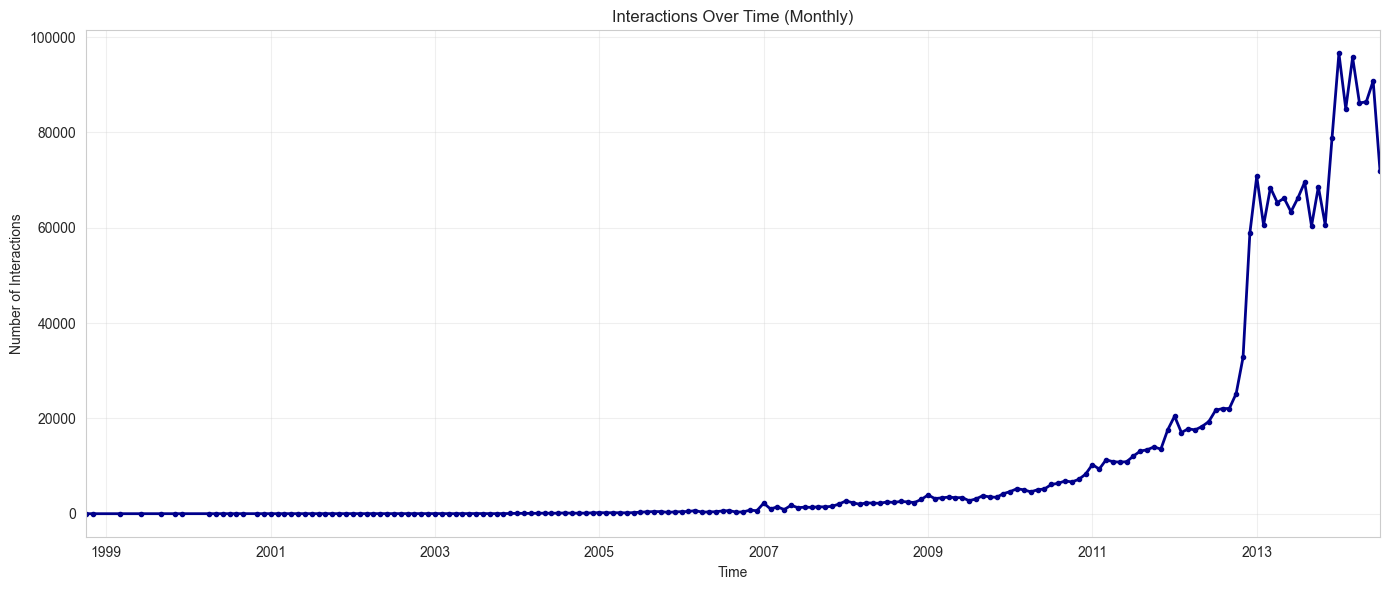


Temporal Patterns:
  Most active month: 2014-01 (96,588 interactions)
  Least active month: 1998-10 (1 interactions)


In [13]:
# Temporal visualizations 
if timestamp_col and 'datetime' in df.columns:
    # Interactions over time
    df['year_month'] = df['datetime'].dt.to_period('M')
    interactions_over_time = df.groupby('year_month').size()
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Time series plot
    interactions_over_time.plot(ax=ax, linewidth=2, color='darkblue', marker='o', markersize=3)
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Interactions')
    ax.set_title('Interactions Over Time (Monthly)')
    ax.grid(True, alpha=0.3)
    ax.fill_between(range(len(interactions_over_time)), interactions_over_time.values, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTemporal Patterns:")
    print(f"  Most active month: {interactions_over_time.idxmax()} ({interactions_over_time.max():,} interactions)")
    print(f"  Least active month: {interactions_over_time.idxmin()} ({interactions_over_time.min():,} interactions)")
else:
    print("Temporal analysis skipped: No valid timestamp data available.")


## 6. Data Quality Checks

Detecting duplicates, outliers, and data consistency issues.


In [14]:
# Data quality checks
print("Data Quality Report:")
print("=" * 70)

# 1. Duplicates
duplicate_rows = df.duplicated().sum()
duplicate_pairs = df.duplicated(subset=['user_id:token', 'item_id:token'], keep=False).sum()
print(f"\n1. Duplicate Analysis:")
print(f"   Exact duplicate rows: {duplicate_rows:,} ({duplicate_rows/len(df)*100:.4f}%)")
print(f"   Duplicate user-item pairs: {duplicate_pairs:,} ({duplicate_pairs/len(df)*100:.4f}%)")

# 2. Missing values (already checked earlier but recap)
print(f"\n2. Missing Values:")
missing_summary = df.isnull().sum()
if missing_summary.sum() == 0:
    print(f"   No missing values found ")
else:
    for col, count in missing_summary[missing_summary > 0].items():
        print(f"   {col}: {count:,} ({count/len(df)*100:.2f}%)")

# 3. Data types consistency
print(f"\n3. Data Type Consistency:")
print(f"   user_id type: {df['user_id:token'].dtype}")
print(f"   item_id type: {df['item_id:token'].dtype}")
if 'rating:float' in df.columns:
    print(f"   rating type: {df['rating:float'].dtype}")
    

# 4. Check if IDs are sequential/remapped
print(f"\n4. ID Mapping Status:")

# Check if IDs are numeric by attempting conversion on entire column
# Use errors='coerce' to convert non-numeric values to NaN
user_ids_converted = pd.to_numeric(df['user_id:token'], errors='coerce')
item_ids_converted = pd.to_numeric(df['item_id:token'], errors='coerce')

# Check if all values were successfully converted (no NaNs)
user_ids_numeric = user_ids_converted.notna().all()
item_ids_numeric = item_ids_converted.notna().all()

# Report based on whether IDs are numeric or not
if user_ids_numeric:
    user_id_sequential = (user_ids_converted.nunique() == user_ids_converted.max() + 1 - user_ids_converted.min())
    print(f"   User IDs: Numeric, {'Sequential (0 to N-1)' if user_id_sequential else 'Sparse/Non-sequential'}")
else:
    print(f"   User IDs: Alphanumeric strings (not numerically sequential)")

if item_ids_numeric:
    item_id_sequential = (item_ids_converted.nunique() == item_ids_converted.max() + 1 - item_ids_converted.min())
    print(f"   Item IDs: Numeric, {'Sequential (0 to N-1)' if item_id_sequential else 'Sparse/Non-sequential'}")
else:
    print(f"   Item IDs: Alphanumeric strings (not numerically sequential)")

print("=" * 70)



Data Quality Report:

1. Duplicate Analysis:
   Exact duplicate rows: 0 (0.0000%)
   Duplicate user-item pairs: 0 (0.0000%)

2. Missing Values:
   No missing values found 

3. Data Type Consistency:
   user_id type: object
   item_id type: object
   rating type: float64

4. ID Mapping Status:
   User IDs: Alphanumeric strings (not numerically sequential)
   Item IDs: Alphanumeric strings (not numerically sequential)



Outlier Detection:

1. User Outliers (interactions > 4):
   Count: 82,659 users (6.83%)
   These users account for 590,911 interactions (29.21%)

2. Item Outliers (interactions > 11):
   Count: 31,337 items (12.57%)
   These items account for 1,456,065 interactions (71.97%)


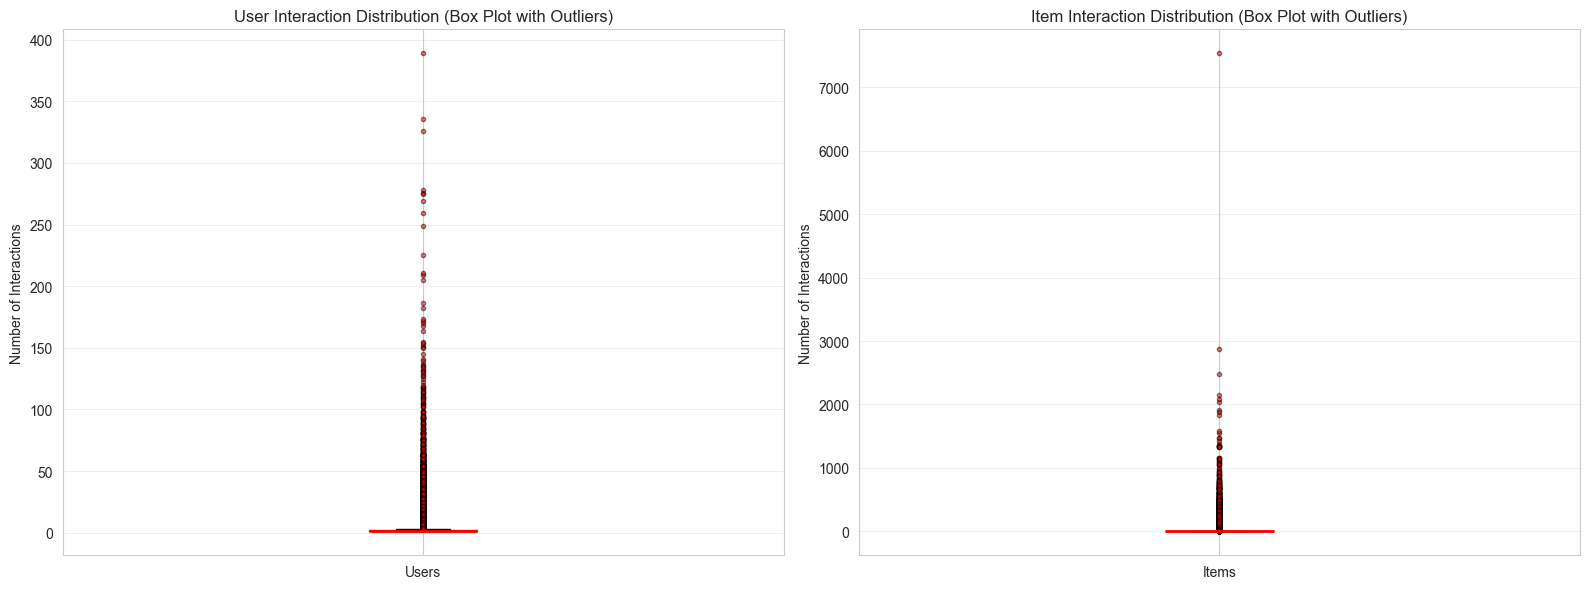

In [15]:
# Outlier detection: Users/Items with extreme behavior
print("\nOutlier Detection:")
print("=" * 70)

# User outliers (using IQR method)
Q1_user = interactions_per_user.quantile(0.25)
Q3_user = interactions_per_user.quantile(0.75)
IQR_user = Q3_user - Q1_user
outlier_threshold_user = Q3_user + 1.5 * IQR_user

user_outliers = interactions_per_user[interactions_per_user > outlier_threshold_user]
print(f"\n1. User Outliers (interactions > {outlier_threshold_user:.0f}):")
print(f"   Count: {len(user_outliers):,} users ({len(user_outliers)/n_users*100:.2f}%)")
print(f"   These users account for {user_outliers.sum():,} interactions ({user_outliers.sum()/n_interactions*100:.2f}%)")

# Item outliers
Q1_item = interactions_per_item.quantile(0.25)
Q3_item = interactions_per_item.quantile(0.75)
IQR_item = Q3_item - Q1_item
outlier_threshold_item = Q3_item + 1.5 * IQR_item

item_outliers = interactions_per_item[interactions_per_item > outlier_threshold_item]
print(f"\n2. Item Outliers (interactions > {outlier_threshold_item:.0f}):")
print(f"   Count: {len(item_outliers):,} items ({len(item_outliers)/n_items*100:.2f}%)")
print(f"   These items account for {item_outliers.sum():,} interactions ({item_outliers.sum()/n_interactions*100:.2f}%)")

# Visualize outliers
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# User outliers
axes[0].boxplot(interactions_per_user, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
axes[0].set_ylabel('Number of Interactions')
axes[0].set_title('User Interaction Distribution (Box Plot with Outliers)')
axes[0].set_xticklabels(['Users'])
axes[0].grid(True, alpha=0.3, axis='y')

# Item outliers
axes[1].boxplot(interactions_per_item, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightgreen', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.5))
axes[1].set_ylabel('Number of Interactions')
axes[1].set_title('Item Interaction Distribution (Box Plot with Outliers)')
axes[1].set_xticklabels(['Items'])
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("=" * 70)


In [16]:
# Preprocessing effects

# Check if the filter was effective
users_with_5 = (interactions_per_user == 5).sum()
items_with_5 = (interactions_per_item == 5).sum()

print(f"\nUsers/Items at minimum threshold:")
print(f"  Users with exactly 5 interactions: {users_with_5:,} ({users_with_5/n_users*100:.2f}%)")
print(f"  Items with exactly 5 interactions: {items_with_5:,} ({items_with_5/n_items*100:.2f}%)")
print("=" * 70)



Users/Items at minimum threshold:
  Users with exactly 5 interactions: 16,187 (1.34%)
  Items with exactly 5 interactions: 9,623 (3.86%)


RecBole preprocessing applied filters:

  min_user_inter_num: 5
  
  min_item_inter_num: 5

This means:

   All users have at least 5 interactions

   All items have at least 5 interactions

   Cold-start problem is partially mitigated for training
   
   But new users/items at inference time will still have cold-start issues


## 7. Train/Valid/Test Split Analysis

Understanding data distribution across splits.


In [17]:
# Load split files if available
import os

base_path = 'dataset/amazon-beauty'
train_file = f'{base_path}/amazon-beauty-train.inter'
valid_file = f'{base_path}/amazon-beauty-valid.inter'
test_file = f'{base_path}/amazon-beauty-test.inter'

splits_exist = all([os.path.exists(f) for f in [train_file, valid_file, test_file]])

if splits_exist:
    print("Split files found. Loading")
    df_train = pd.read_csv(train_file, sep='\t')
    df_valid = pd.read_csv(valid_file, sep='\t')
    df_test = pd.read_csv(test_file, sep='\t')
    
    print("\nSplit Sizes:")
    print("=" * 70)
    total_split = len(df_train) + len(df_valid) + len(df_test)
    print(f"  Train: {len(df_train):>10,} ({len(df_train)/total_split*100:>5.2f}%)")
    print(f"  Valid: {len(df_valid):>10,} ({len(df_valid)/total_split*100:>5.2f}%)")
    print(f"  Test:  {len(df_test):>10,} ({len(df_test)/total_split*100:>5.2f}%)")
    print(f"  Total: {total_split:>10,}")
    print("=" * 70)
else:
    print("Split files not found. Run RecBole preprocessing or training first to generate splits.")
    print(f"\nExpected files:")
    print(f"  - {train_file}")
    print(f"  - {valid_file}")
    print(f"  - {test_file}")


Split files found. Loading

Split Sizes:
  Train:  1,541,321 (76.19%)
  Valid:    152,937 ( 7.56%)
  Test:     328,812 (16.25%)
  Total:  2,023,070


In [18]:
# Analyze split characteristics
if splits_exist:
    print("\nSplit Characteristics:")
    print("=" * 70)
    
    # User/Item overlap
    train_users = set(df_train['user_id'].unique())
    valid_users = set(df_valid['user_id'].unique())
    test_users = set(df_test['user_id'].unique())
    
    train_items = set(df_train['item_id'].unique())
    valid_items = set(df_valid['item_id'].unique())
    test_items = set(df_test['item_id'].unique())
    
    print(f"\nUser Coverage:")
    print(f"  Train users: {len(train_users):,}")
    print(f"  Valid users: {len(valid_users):,} ({len(valid_users.intersection(train_users))/len(valid_users)*100:.1f}% overlap with train)")
    print(f"  Test users: {len(test_users):,} ({len(test_users.intersection(train_users))/len(test_users)*100:.1f}% overlap with train)")
    
    print(f"\nItem Coverage:")
    print(f"  Train items: {len(train_items):,}")
    print(f"  Valid items: {len(valid_items):,} ({len(valid_items.intersection(train_items))/len(valid_items)*100:.1f}% overlap with train)")
    print(f"  Test items: {len(test_items):,} ({len(test_items.intersection(train_items))/len(test_items)*100:.1f}% overlap with train)")
    
    # Cold-start analysis
    valid_new_users = valid_users - train_users
    test_new_users = test_users - train_users
    valid_new_items = valid_items - train_items
    test_new_items = test_items - train_items
    
    print(f"\nCold-Start Analysis:")
    print(f"  Valid: {len(valid_new_users)} new users, {len(valid_new_items)} new items")
    print(f"  Test: {len(test_new_users)} new users, {len(test_new_items)} new items")
    
    print("=" * 70)



Split Characteristics:

User Coverage:
  Train users: 1,210,271
  Valid users: 146,995 (100.0% overlap with train)
  Test users: 322,870 (100.0% overlap with train)

Item Coverage:
  Train items: 212,506
  Valid items: 63,445 (82.5% overlap with train)
  Test items: 108,510 (74.7% overlap with train)

Cold-Start Analysis:
  Valid: 0 new users, 11074 new items
  Test: 0 new users, 27431 new items


## 8. Item Dataset Analysis

Analyzing item metadata to understand feature availability, quality, and potential for content-based and hybrid recommendation models.


### 8.1 Load Item Data


In [19]:
# Load item metadata
item_file = 'dataset/amazon-beauty/amazon-beauty.item'
df_item = pd.read_csv(item_file, sep='\t')

print(f"Item metadata loaded: {item_file}")
print(f"Shape: {df_item.shape}")
print(f"\nColumn names: {list(df_item.columns)}")
print(f"\nFirst few rows:")
df_item.head(10)


Item metadata loaded: dataset/amazon-beauty/amazon-beauty.item
Shape: (259204, 7)

Column names: ['item_id:token', 'title:token', 'sales_type:token', 'sales_rank:float', 'categories:token_seq', 'price:float', 'brand:token']

First few rows:


,item_id:token,title:token,sales_type:token,sales_rank:float,categories:token_seq,price:float,brand:token
0,0205616461,Bio-Active Anti-Aging Serum (Firming Ultra-Hyd...,Health & Personal Care,461765.0,"'Beauty', 'Skin Care', 'Face', 'Creams & Moist...",NaN,NaN
1,0558925278,Eco Friendly Ecotools Quality Natural Bamboo C...,Beauty,402875.0,"'Beauty', 'Tools & Accessories', 'Makeup Brush...",NaN,NaN
2,0733001998,Mastiha Body Lotion,Beauty,540255.0,"'Beauty', 'Skin Care', 'Body', 'Moisturizers',...",NaN,NaN
3,0737104473,Hello Kitty Lustre Lipstick (See sellers comme...,Beauty,931125.0,"'Beauty', 'Makeup', 'Lips', 'Lipstick'",NaN,NaN
4,0762451459,Stephanie Johnson Mermaid Round Snap Mirror,NaN,NaN,"'Beauty', 'Tools & Accessories', 'Mirrors', 'M...",19.98,NaN
5,1304139212,Set of 2 MAC Lip Care - Lip Pencil - Auburn,Beauty,830938.0,"'Beauty', 'Makeup', 'Lips', 'Lip Liners'",NaN,NaN
6,130414674X,Set of 2 Benefit She Laq Makeup Sealer,Beauty,678207.0,"'Beauty', 'Makeup', 'Makeup Sets'",NaN,NaN
7,130414089X,New Benefit Waterproof Automatic Eyeliner Pen ...,Beauty,205621.0,"'Beauty', 'Makeup', 'Eyes', 'Eyeliner'",NaN,NaN
8,1304196062,Max Factor Lasting Performance Foundation -Pas...,Beauty,774050.0,"'Beauty', 'Makeup', 'Face', 'Foundation'",NaN,NaN
9,1304146537,Set of 2 Goodskin Labs Eyliplex-2 Eye Life and...,Beauty,371552.0,"'Beauty', 'Skin Care', 'Eyes', 'Dark Circle Tr...",NaN,NaN


In [20]:
# Data types and basic info
print("Item Dataset Info:")
print("=" * 70)
df_item.info()
print("\n" + "=" * 70)



Item Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259204 entries, 0 to 259203
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   item_id:token         259204 non-null  object 
 1   title:token           258760 non-null  object 
 2   sales_type:token      253985 non-null  object 
 3   sales_rank:float      253985 non-null  float64
 4   categories:token_seq  259204 non-null  object 
 5   price:float           189930 non-null  float64
 6   brand:token           127037 non-null  object 
dtypes: float64(2), object(5)
memory usage: 13.8+ MB



### 8.2 Missing Value Analysis


In [21]:
# Missing values analysis
print("Missing Values in Item Dataset:")
print("=" * 70)

missing_item = df_item.isnull().sum()
missing_item_pct = (missing_item / len(df_item)) * 100

missing_item_df = pd.DataFrame({
    'Column': missing_item.index,
    'Missing Count': missing_item.values,
    'Percentage': missing_item_pct.values
}).sort_values('Missing Count', ascending=False)

print(missing_item_df.to_string(index=False))
print("=" * 70)

# Summary
total_items = len(df_item)
items_with_any_missing = df_item.isnull().any(axis=1).sum()
items_complete = total_items - items_with_any_missing

print(f"\nSummary:")
print(f"  Total items: {total_items:,}")
print(f"  Items with complete data: {items_complete:,} ({items_complete/total_items*100:.2f}%)")
print(f"  Items with any missing data: {items_with_any_missing:,} ({items_with_any_missing/total_items*100:.2f}%)")


Missing Values in Item Dataset:
              Column  Missing Count  Percentage
         brand:token         132167     50.9896
         price:float          69274     26.7257
    sales_type:token           5219      2.0135
    sales_rank:float           5219      2.0135
         title:token            444      0.1713
       item_id:token              0      0.0000
categories:token_seq              0      0.0000

Summary:
  Total items: 259,204
  Items with complete data: 124,730 (48.12%)
  Items with any missing data: 134,474 (51.88%)


### 8.3 Item-Interaction Alignment

Checking alignment between items in interactions and items with metadata.


In [22]:
# Check item alignment between interactions and metadata
items_in_interactions = set(df['item_id:token'].unique())
items_in_metadata = set(df_item['item_id:token'].unique())

items_both = items_in_interactions & items_in_metadata
items_only_interactions = items_in_interactions - items_in_metadata
items_only_metadata = items_in_metadata - items_in_interactions

print("Item Alignment Analysis:")
print("=" * 70)
print(f"Items in interaction data: {len(items_in_interactions):,}")
print(f"Items in metadata: {len(items_in_metadata):,}")
print(f"Items in both: {len(items_both):,}")
print(f"\nItems with interactions but NO metadata: {len(items_only_interactions):,}")
print(f"Items with metadata but NO interactions: {len(items_only_metadata):,}")
print(f"\nOverlap percentage: {len(items_both)/len(items_in_interactions)*100:.2f}%")
print("=" * 70)

if len(items_only_interactions) > 0:
    print(f"\n  WARNING: {len(items_only_interactions)} items have interactions but missing metadata!")
    print("   This may affect content-based and hybrid models.")
else:
    print(f"\nAll items with interactions have metadata (100% coverage)")


Item Alignment Analysis:
Items in interaction data: 249,274
Items in metadata: 259,204
Items in both: 249,274

Items with interactions but NO metadata: 0
Items with metadata but NO interactions: 9,930

Overlap percentage: 100.00%

All items with interactions have metadata (100% coverage)


### 8.4 Numerical Features Analysis

Analyzing price and sales rank distributions.


In [23]:
# Price Analysis
print("Price Distribution Analysis:")
print("=" * 70)

if 'price:float' in df_item.columns:
    price_data = df_item['price:float'].dropna()
    
    if len(price_data) > 0:
        print(f"Total items: {len(df_item):,}")
        print(f"Items with price data: {len(price_data):,} ({len(price_data)/len(df_item)*100:.2f}%)")
        print(f"Items without price: {df_item['price:float'].isnull().sum():,}\n")
        
        print("Price Statistics:")
        print(f"  Mean: ${price_data.mean():.2f}")
        print(f"  Median: ${price_data.median():.2f}")
        print(f"  Std Dev: ${price_data.std():.2f}")
        print(f"  Min: ${price_data.min():.2f}")
        print(f"  Max: ${price_data.max():.2f}")
        print(f"  25th percentile: ${price_data.quantile(0.25):.2f}")
        print(f"  75th percentile: ${price_data.quantile(0.75):.2f}")
        print(f"  99th percentile: ${price_data.quantile(0.99):.2f}")
        print(f"  Skewness: {price_data.skew():.2f}")
    else:
        print("No price data available")
else:
    print("Price column not found")

print("=" * 70)


Price Distribution Analysis:
Total items: 259,204
Items with price data: 189,930 (73.27%)
Items without price: 69,274

Price Statistics:
  Mean: $24.88
  Median: $15.69
  Std Dev: $33.43
  Min: $0.01
  Max: $999.99
  25th percentile: $8.24
  75th percentile: $29.30
  99th percentile: $159.99
  Skewness: 7.04


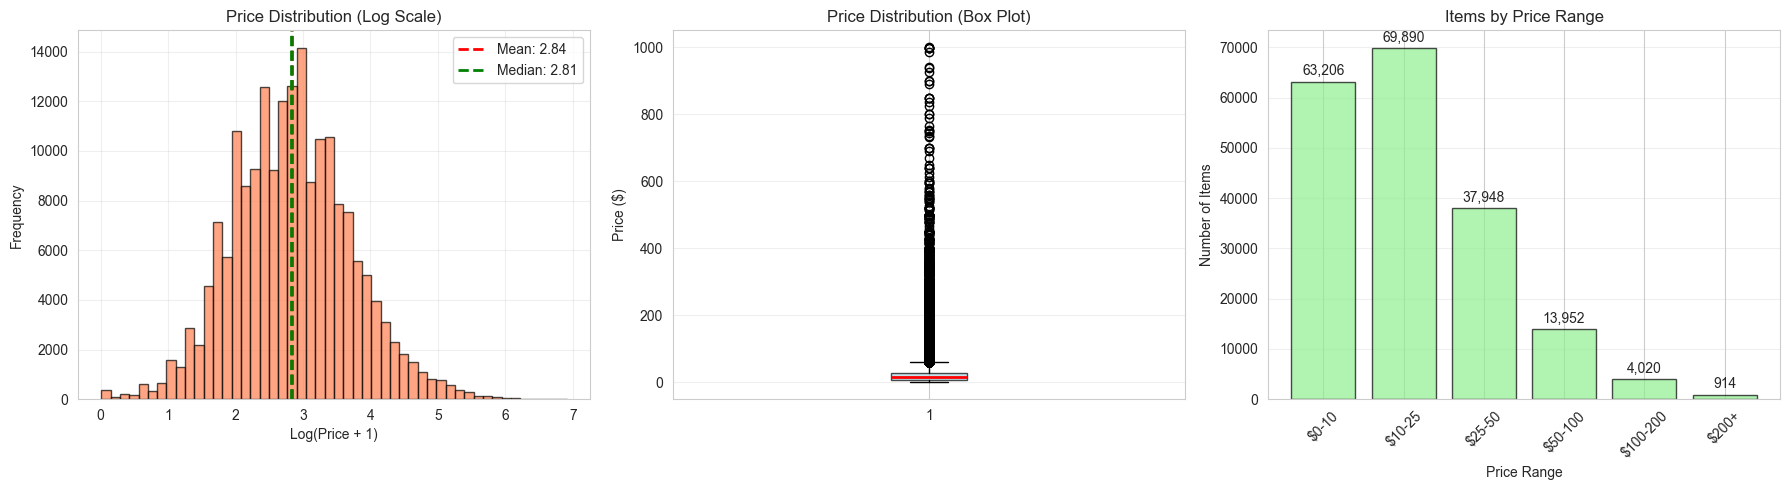


Price Range Distribution:
  $0-10: 63,206 items (33.28%)
  $10-25: 69,890 items (36.80%)
  $25-50: 37,948 items (19.98%)
  $50-100: 13,952 items (7.35%)
  $100-200: 4,020 items (2.12%)
  $200+: 914 items (0.48%)


In [24]:
# Visualize price distribution
if 'price:float' in df_item.columns and len(price_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram - log scale (for better visualization)
    log_price = np.log1p(price_data)  # log(1+x) to handle zeros
    axes[0].hist(log_price, bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[0].set_xlabel('Log(Price + 1)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Price Distribution (Log Scale)')
    axes[0].axvline(log_price.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {log_price.mean():.2f}')
    axes[0].axvline(log_price.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {log_price.median():.2f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(price_data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    axes[1].set_ylabel('Price ($)')
    axes[1].set_title('Price Distribution (Box Plot)')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Price ranges
    price_ranges = pd.cut(price_data, bins=[0, 10, 25, 50, 100, 200, price_data.max()], 
                          labels=['$0-10', '$10-25', '$25-50', '$50-100', '$100-200', '$200+'])
    range_counts = price_ranges.value_counts().sort_index()
    
    axes[2].bar(range(len(range_counts)), range_counts.values, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[2].set_xticks(range(len(range_counts)))
    axes[2].set_xticklabels(range_counts.index, rotation=45)
    axes[2].set_xlabel('Price Range')
    axes[2].set_ylabel('Number of Items')
    axes[2].set_title('Items by Price Range')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    # Add counts on bars
    for i, v in enumerate(range_counts.values):
        axes[2].text(i, v + max(range_counts.values)*0.01, f'{v:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrice Range Distribution:")
    for price_range, count in range_counts.items():
        print(f"  {price_range}: {count:,} items ({count/len(price_data)*100:.2f}%)")
else:
    print("Cannot visualize price: No data available")


In [25]:
# Sales Rank Analysis
print("Sales Rank Distribution Analysis:")
print("=" * 70)

if 'sales_rank:float' in df_item.columns:
    sales_rank_data = df_item['sales_rank:float'].dropna()
    
    if len(sales_rank_data) > 0:
        print(f"Total items: {len(df_item):,}")
        print(f"Items with sales rank data: {len(sales_rank_data):,} ({len(sales_rank_data)/len(df_item)*100:.2f}%)")
        print(f"Items without sales rank: {df_item['sales_rank:float'].isnull().sum():,}\n")
        
        print("Sales Rank Statistics:")
        print(f"  Mean: {sales_rank_data.mean():,.0f}")
        print(f"  Median: {sales_rank_data.median():,.0f}")
        print(f"  Std Dev: {sales_rank_data.std():,.0f}")
        print(f"  Min: {sales_rank_data.min():,.0f}")
        print(f"  Max: {sales_rank_data.max():,.0f}")
        print(f"  25th percentile: {sales_rank_data.quantile(0.25):,.0f}")
        print(f"  75th percentile: {sales_rank_data.quantile(0.75):,.0f}")
        print(f"  99th percentile: {sales_rank_data.quantile(0.99):,.0f}")
        print(f"\nNote: Lower sales rank = More popular item")
    else:
        print("No sales rank data available")
else:
    print("Sales rank column not found")

print("=" * 70)


Sales Rank Distribution Analysis:
Total items: 259,204
Items with sales rank data: 253,985 (97.99%)
Items without sales rank: 5,219

Sales Rank Statistics:
  Mean: 301,303
  Median: 230,312
  Std Dev: 281,673
  Min: 1
  Max: 5,244,410
  25th percentile: 92,617
  75th percentile: 429,914
  99th percentile: 1,149,874

Note: Lower sales rank = More popular item


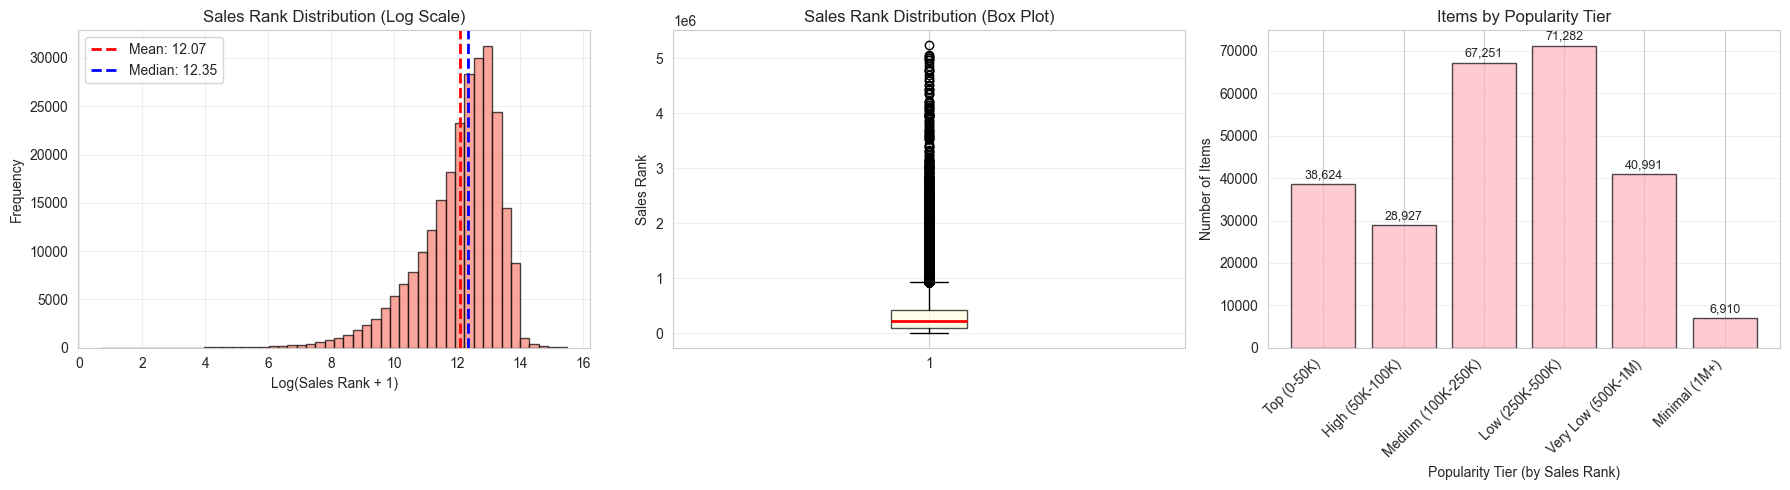


Sales Rank Distribution by Tier:
  Top (0-50K): 38,624 items (15.21%)
  High (50K-100K): 28,927 items (11.39%)
  Medium (100K-250K): 67,251 items (26.48%)
  Low (250K-500K): 71,282 items (28.07%)
  Very Low (500K-1M): 40,991 items (16.14%)
  Minimal (1M+): 6,910 items (2.72%)


In [26]:
# Visualize sales rank distribution
if 'sales_rank:float' in df_item.columns and len(sales_rank_data) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Histogram - log scale
    log_sales_rank = np.log1p(sales_rank_data)
    axes[0].hist(log_sales_rank, bins=50, edgecolor='black', alpha=0.7, color='salmon')
    axes[0].set_xlabel('Log(Sales Rank + 1)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Sales Rank Distribution (Log Scale)')
    axes[0].axvline(log_sales_rank.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {log_sales_rank.mean():.2f}')
    axes[0].axvline(log_sales_rank.median(), color='blue', linestyle='--', linewidth=2, label=f'Median: {log_sales_rank.median():.2f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(sales_rank_data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightyellow', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))
    axes[1].set_ylabel('Sales Rank')
    axes[1].set_title('Sales Rank Distribution (Box Plot)')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Rank popularity (inverted for better understanding: lower rank = higher popularity)
    sales_rank_ranges = pd.cut(sales_rank_data, 
                                bins=[0, 50000, 100000, 250000, 500000, 1000000, sales_rank_data.max()],
                                labels=['Top (0-50K)', 'High (50K-100K)', 'Medium (100K-250K)', 
                                       'Low (250K-500K)', 'Very Low (500K-1M)', 'Minimal (1M+)'])
    range_counts = sales_rank_ranges.value_counts().sort_index()
    
    axes[2].bar(range(len(range_counts)), range_counts.values, color='lightpink', edgecolor='black', alpha=0.7)
    axes[2].set_xticks(range(len(range_counts)))
    axes[2].set_xticklabels(range_counts.index, rotation=45, ha='right')
    axes[2].set_xlabel('Popularity Tier (by Sales Rank)')
    axes[2].set_ylabel('Number of Items')
    axes[2].set_title('Items by Popularity Tier')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    # Add counts on bars
    for i, v in enumerate(range_counts.values):
        axes[2].text(i, v + max(range_counts.values)*0.01, f'{v:,}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nSales Rank Distribution by Tier:")
    for rank_range, count in range_counts.items():
        print(f"  {rank_range}: {count:,} items ({count/len(sales_rank_data)*100:.2f}%)")
else:
    print("Cannot visualize sales rank: No data available")


### 8.5 Categorical Features Analysis

Analyzing brand, sales type, and their distributions.


In [27]:
# Sales Type Analysis
print("Sales Type Distribution:")
print("=" * 70)

if 'sales_type:token' in df_item.columns:
    sales_type_counts = df_item['sales_type:token'].value_counts()
    sales_type_missing = df_item['sales_type:token'].isnull().sum()
    
    print(f"Total items: {len(df_item):,}")
    print(f"Items with sales type: {len(df_item) - sales_type_missing:,}")
    print(f"Items without sales type: {sales_type_missing:,} ({sales_type_missing/len(df_item)*100:.2f}%)\n")
    
    if len(sales_type_counts) > 0:
        print(f"Number of unique sales types: {len(sales_type_counts)}\n")
        print("Sales Type Breakdown:")
        for sales_type, count in sales_type_counts.items():
            pct = count / len(df_item) * 100
            bar = '█' * int(pct / 2)
            print(f"  {sales_type:<30}: {count:>8,} ({pct:>5.2f}%) {bar}")
    else:
        print("No sales type data available")
else:
    print("Sales type column not found")

print("=" * 70)


Sales Type Distribution:
Total items: 259,204
Items with sales type: 253,985
Items without sales type: 5,219 (2.01%)

Number of unique sales types: 29

Sales Type Breakdown:
  Beauty                        :  215,131 (83.00%) █████████████████████████████████████████
  Health & Personal Care        :   30,479 (11.76%) █████
  Clothing                      :    2,448 ( 0.94%) 
  Home &amp; Kitchen            :    1,421 ( 0.55%) 
  Sports &amp; Outdoors         :      683 ( 0.26%) 
  Toys & Games                  :      642 ( 0.25%) 
  Music                         :      568 ( 0.22%) 
  Shoes                         :      551 ( 0.21%) 
  Jewelry                       :      534 ( 0.21%) 
  Industrial & Scientific       :      399 ( 0.15%) 
  Arts, Crafts & Sewing         :      272 ( 0.10%) 
  Pet Supplies                  :      268 ( 0.10%) 
  Kitchen & Dining              :      202 ( 0.08%) 
  Electronics                   :      137 ( 0.05%) 
  Patio, Lawn & Garden          :     

In [28]:
# Brand Analysis
print("Brand Distribution:")
print("=" * 70)

if 'brand:token' in df_item.columns:
    brand_counts = df_item['brand:token'].value_counts()
    brand_missing = df_item['brand:token'].isnull().sum()
    
    print(f"Total items: {len(df_item):,}")
    print(f"Items with brand: {len(df_item) - brand_missing:,} ({(len(df_item) - brand_missing)/len(df_item)*100:.2f}%)")
    print(f"Items without brand: {brand_missing:,} ({brand_missing/len(df_item)*100:.2f}%)\n")
    
    if len(brand_counts) > 0:
        print(f"Number of unique brands: {len(brand_counts):,}\n")
        
        # Top 20 brands
        print("Top 20 Brands by Item Count:")
        top_brands = brand_counts.head(20)
        for i, (brand, count) in enumerate(top_brands.items(), 1):
            pct = count / (len(df_item) - brand_missing) * 100
            print(f"  {i:>2}. {str(brand):<40}: {count:>6,} ({pct:>5.2f}%)")
        
        # Long-tail analysis
        print(f"\nBrand Concentration Analysis:")
        cumsum = brand_counts.cumsum()
        total_with_brand = len(df_item) - brand_missing
        
        for pct in [20, 50, 80]:
            n_brands = (cumsum <= total_with_brand * pct/100).sum() + 1
            print(f"  Top {n_brands:,} brands account for {pct}% of items")
        
        # Single-item brands
        single_item_brands = (brand_counts == 1).sum()
        print(f"\n  Brands with only 1 item: {single_item_brands:,} ({single_item_brands/len(brand_counts)*100:.2f}%)")
        print(f"  Brands with 2-10 items: {((brand_counts > 1) & (brand_counts <= 10)).sum():,}")
        print(f"  Brands with 11-100 items: {((brand_counts > 10) & (brand_counts <= 100)).sum():,}")
        print(f"  Brands with 100+ items: {(brand_counts > 100).sum():,}")
    else:
        print("No brand data available")
else:
    print("Brand column not found")

print("=" * 70)


Brand Distribution:
Total items: 259,204
Items with brand: 127,037 (49.01%)
Items without brand: 132,167 (50.99%)

Number of unique brands: 13,186

Top 20 Brands by Item Count:
   1. L&#39;Oreal Paris                       :  1,985 ( 1.56%)
   2. OPI                                     :  1,966 ( 1.55%)
   3. Revlon                                  :  1,418 ( 1.12%)
   4. Bath &amp; Body Works                   :  1,325 ( 1.04%)
   5. Maybelline                              :  1,188 ( 0.94%)
   6. Essie                                   :    901 ( 0.71%)
   7. COVERGIRL                               :    874 ( 0.69%)
   8. M.A.C                                   :    870 ( 0.68%)
   9. Victoria&#39;s Secret                   :    848 ( 0.67%)
  10. Clinique                                :    806 ( 0.63%)
  11. NYX                                     :    782 ( 0.62%)
  12. Bare Escentuals                         :    774 ( 0.61%)
  13. Sally Hansen                            :    762 

### 8.6 Category Hierarchy Analysis

Analyzing the hierarchical category structure.


In [29]:
# Parse category hierarchies
print("Category Hierarchy Analysis:")
print("=" * 70)

if 'categories:token_seq' in df_item.columns:
    categories_col = df_item['categories:token_seq']
    categories_missing = categories_col.isnull().sum()
    
    print(f"Total items: {len(df_item):,}")
    print(f"Items with categories: {len(df_item) - categories_missing:,} ({(len(df_item) - categories_missing)/len(df_item)*100:.2f}%)")
    print(f"Items without categories: {categories_missing:,} ({categories_missing/len(df_item)*100:.2f}%)\n")
    
    # Parse category sequences
    def parse_categories(cat_str):
        if pd.isna(cat_str):
            return []
        # Remove quotes and split by comma
        cats = [c.strip().strip("'\"") for c in str(cat_str).split(',')]
        return [c for c in cats if c]
    
    df_item['category_list'] = categories_col.apply(parse_categories)
    df_item['category_depth'] = df_item['category_list'].apply(len)
    
    # Category depth distribution
    depth_counts = df_item[df_item['category_depth'] > 0]['category_depth'].value_counts().sort_index()
    
    print("Category Depth Distribution:")
    if len(depth_counts) > 0:
        for depth, count in depth_counts.items():
            pct = count / (len(df_item) - categories_missing) * 100
            print(f"  Level {depth}: {count:>8,} items ({pct:>5.2f}%)")
        
        print(f"\nAverage category depth: {df_item[df_item['category_depth'] > 0]['category_depth'].mean():.2f}")
        print(f"Median category depth: {df_item[df_item['category_depth'] > 0]['category_depth'].median():.0f}")
    else:
        print("No category depth data available")
    
else:
    print("Categories column not found")

print("=" * 70)


Category Hierarchy Analysis:
Total items: 259,204
Items with categories: 259,204 (100.00%)
Items without categories: 0 (0.00%)

Category Depth Distribution:
  Level 2:    5,447 items ( 2.10%)
  Level 3:   30,683 items (11.84%)
  Level 4:  161,309 items (62.23%)
  Level 5:   59,260 items (22.86%)
  Level 6:    2,505 items ( 0.97%)

Average category depth: 4.09
Median category depth: 4


In [30]:
# Extract and analyze categories at each level
if 'category_list' in df_item.columns:
    # Extract primary, secondary, tertiary categories
    df_item['primary_category'] = df_item['category_list'].apply(lambda x: x[0] if len(x) > 0 else None)
    df_item['secondary_category'] = df_item['category_list'].apply(lambda x: x[1] if len(x) > 1 else None)
    df_item['tertiary_category'] = df_item['category_list'].apply(lambda x: x[2] if len(x) > 2 else None)
    
    # Count categories at each level
    primary_counts = df_item['primary_category'].value_counts()
    secondary_counts = df_item['secondary_category'].value_counts()
    tertiary_counts = df_item['tertiary_category'].value_counts()
    
    print("\nTop Categories by Level:")
    print("=" * 70)
    
    print("\nPrimary Categories (Top 10):")
    for i, (cat, count) in enumerate(primary_counts.head(10).items(), 1):
        pct = count / len(df_item[df_item['primary_category'].notna()]) * 100
        print(f"  {i:>2}. {cat:<35}: {count:>7,} ({pct:>5.2f}%)")
    
    print(f"\nTotal unique primary categories: {len(primary_counts)}")
    
    print("\nSecondary Categories (Top 10):")
    for i, (cat, count) in enumerate(secondary_counts.head(10).items(), 1):
        pct = count / len(df_item[df_item['secondary_category'].notna()]) * 100
        print(f"  {i:>2}. {cat:<35}: {count:>7,} ({pct:>5.2f}%)")
    
    print(f"\nTotal unique secondary categories: {len(secondary_counts)}")
    
    print("\nTertiary Categories (Top 10):")
    for i, (cat, count) in enumerate(tertiary_counts.head(10).items(), 1):
        pct = count / len(df_item[df_item['tertiary_category'].notna()]) * 100
        print(f"  {i:>2}. {cat:<35}: {count:>7,} ({pct:>5.2f}%)")
    
    print(f"\nTotal unique tertiary categories: {len(tertiary_counts)}")
    print("=" * 70)



Top Categories by Level:

Primary Categories (Top 10):
   1. Beauty                             : 259,170 (99.99%)
   2. Health & Personal Care             :      17 ( 0.01%)
   3. Sports & Outdoors                  :      14 ( 0.01%)
   4. Home & Kitchen                     :       2 ( 0.00%)
   5. Tools & Home Improvement           :       1 ( 0.00%)

Total unique primary categories: 5

Secondary Categories (Top 10):
   1. Hair Care                          :  72,736 (28.06%)
   2. Skin Care                          :  64,381 (24.84%)
   3. Makeup                             :  54,044 (20.85%)
   4. Fragrance                          :  26,651 (10.28%)
   5. Tools & Accessories                :  20,852 ( 8.04%)
   6. Bath & Body                        :  20,506 ( 7.91%)
   7. Fan Shop                           :      10 ( 0.00%)
   8. Stationery & Party Supplies        :       7 ( 0.00%)
   9. Personal Care                      :       5 ( 0.00%)
  10. Health Care                   

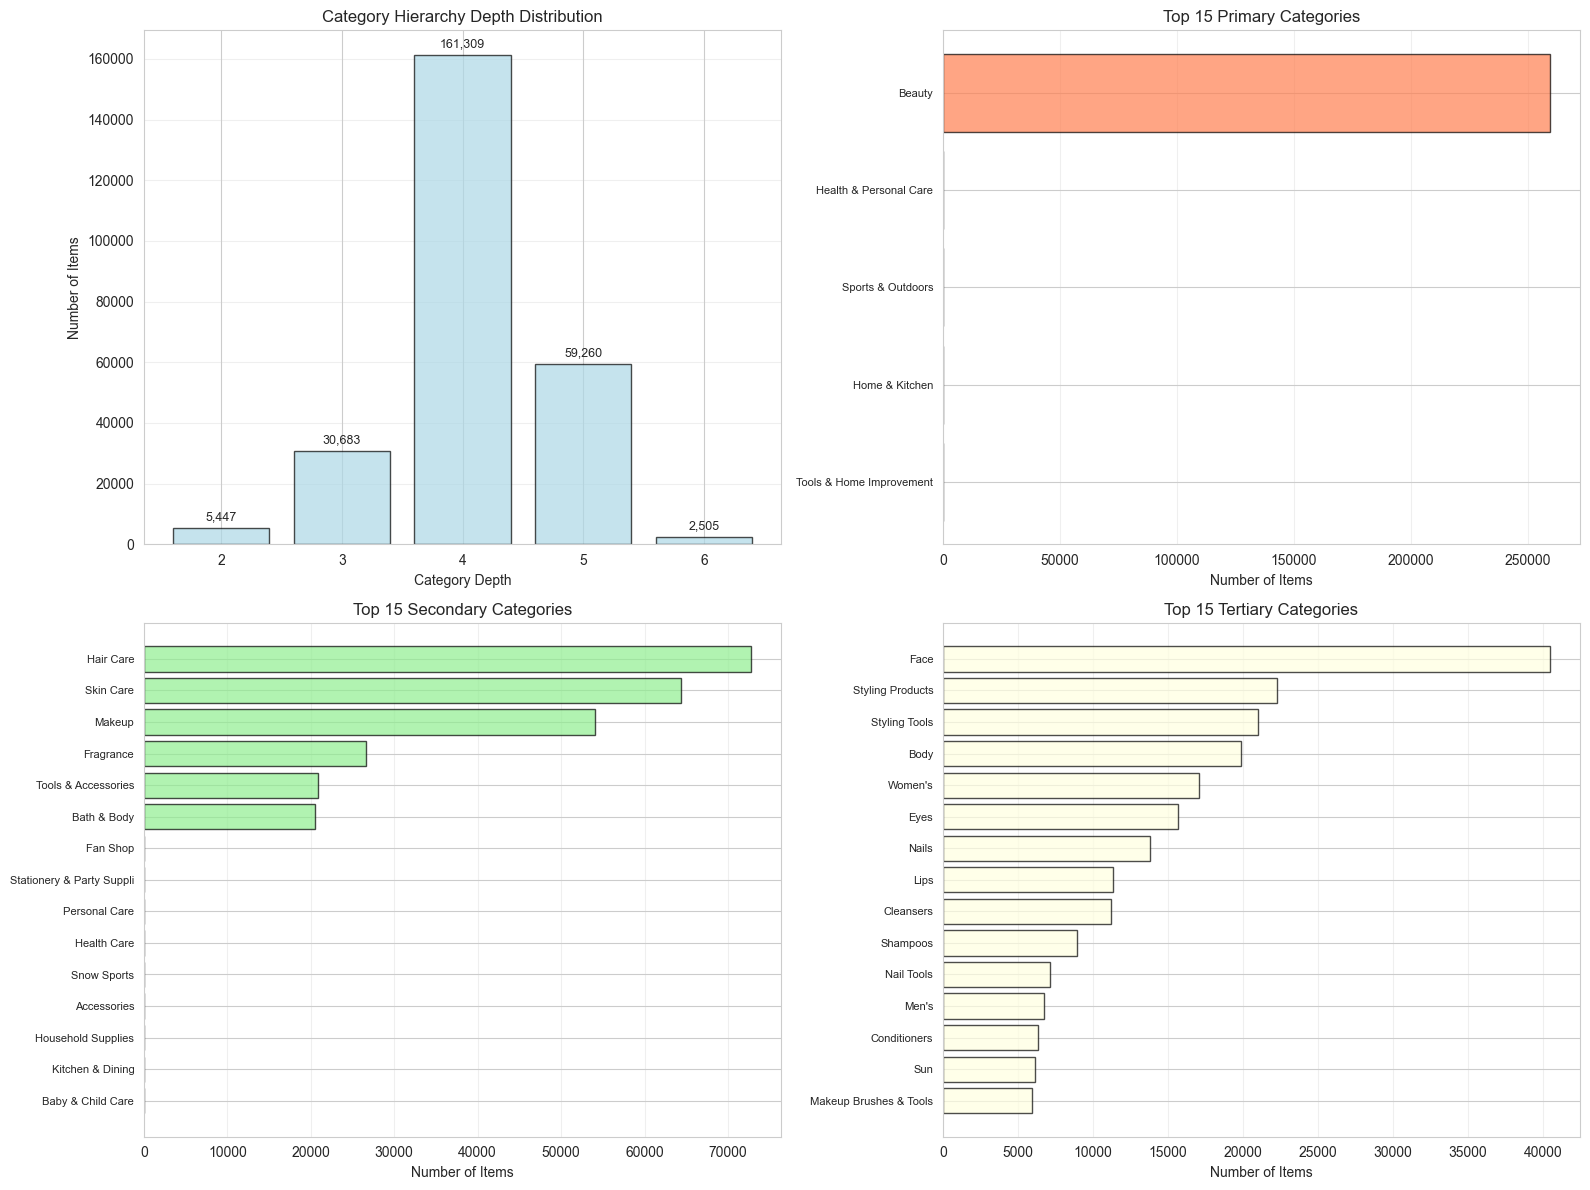

In [31]:
# Visualize category distributions
if 'category_list' in df_item.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Category depth distribution
    depth_counts = df_item[df_item['category_depth'] > 0]['category_depth'].value_counts().sort_index()
    axes[0, 0].bar(depth_counts.index, depth_counts.values, color='lightblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Category Depth')
    axes[0, 0].set_ylabel('Number of Items')
    axes[0, 0].set_title('Category Hierarchy Depth Distribution')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(depth_counts.values):
        axes[0, 0].text(depth_counts.index[i], v + max(depth_counts.values)*0.01, f'{v:,}', 
                       ha='center', va='bottom', fontsize=9)
    
    # Primary categories (top 15)
    top_primary = primary_counts.head(15)
    axes[0, 1].barh(range(len(top_primary)), top_primary.values, color='coral', edgecolor='black', alpha=0.7)
    axes[0, 1].set_yticks(range(len(top_primary)))
    axes[0, 1].set_yticklabels([c[:25] for c in top_primary.index], fontsize=8)
    axes[0, 1].set_xlabel('Number of Items')
    axes[0, 1].set_title('Top 15 Primary Categories')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, axis='x')
    
    # Secondary categories (top 15)
    top_secondary = secondary_counts.head(15)
    axes[1, 0].barh(range(len(top_secondary)), top_secondary.values, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_secondary)))
    axes[1, 0].set_yticklabels([c[:25] for c in top_secondary.index], fontsize=8)
    axes[1, 0].set_xlabel('Number of Items')
    axes[1, 0].set_title('Top 15 Secondary Categories')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Tertiary categories (top 15)
    top_tertiary = tertiary_counts.head(15)
    axes[1, 1].barh(range(len(top_tertiary)), top_tertiary.values, color='lightyellow', edgecolor='black', alpha=0.7)
    axes[1, 1].set_yticks(range(len(top_tertiary)))
    axes[1, 1].set_yticklabels([c[:25] for c in top_tertiary.index], fontsize=8)
    axes[1, 1].set_xlabel('Number of Items')
    axes[1, 1].set_title('Top 15 Tertiary Categories')
    axes[1, 1].invert_yaxis()
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()


### 8.7 Data Quality Checks


In [32]:
# Data quality checks for item metadata
print("Item Data Quality Checks:")
print("=" * 70)

# 1. Duplicate item IDs
duplicate_items = df_item['item_id:token'].duplicated().sum()
print(f"\n1. Duplicate Item IDs:")
print(f"   Count: {duplicate_items}")
if duplicate_items > 0:
    print(f"     WARNING: Found {duplicate_items} duplicate item IDs")
else:
    print(f"    No duplicate item IDs")

# 2. Items with all features missing
all_feature_cols = [c for c in df_item.columns if c != 'item_id:token']
items_all_missing = df_item[all_feature_cols].isnull().all(axis=1).sum()
print(f"\n2. Items with All Features Missing:")
print(f"   Count: {items_all_missing} ({items_all_missing/len(df_item)*100:.2f}%)")
if items_all_missing > 0:
    print(f"     These items have no metadata at all")

# 3. Items with at least some metadata
items_some_metadata = df_item[all_feature_cols].notnull().any(axis=1).sum()
print(f"\n3. Items with At Least Some Metadata:")
print(f"   Count: {items_some_metadata:,} ({items_some_metadata/len(df_item)*100:.2f}%)")

# 4. Feature completeness score (avg features per item)
feature_completeness = df_item[all_feature_cols].notnull().sum(axis=1).mean()
max_features = len(all_feature_cols)
print(f"\n4. Feature Completeness:")
print(f"   Average features per item: {feature_completeness:.2f} / {max_features} ({feature_completeness/max_features*100:.1f}%)")

# 5. Outliers in numerical features
if 'price:float' in df_item.columns:
    price_data = df_item['price:float'].dropna()
    if len(price_data) > 0:
        Q1_price = price_data.quantile(0.25)
        Q3_price = price_data.quantile(0.75)
        IQR_price = Q3_price - Q1_price
        price_outliers = ((price_data < Q1_price - 1.5*IQR_price) | (price_data > Q3_price + 1.5*IQR_price)).sum()
        print(f"\n5. Price Outliers (IQR method):")
        print(f"   Count: {price_outliers:,} ({price_outliers/len(price_data)*100:.2f}%)")
        print(f"   Range: ${Q1_price - 1.5*IQR_price:.2f} to ${Q3_price + 1.5*IQR_price:.2f}")

if 'sales_rank:float' in df_item.columns:
    sales_rank_data = df_item['sales_rank:float'].dropna()
    if len(sales_rank_data) > 0:
        Q1_rank = sales_rank_data.quantile(0.25)
        Q3_rank = sales_rank_data.quantile(0.75)
        IQR_rank = Q3_rank - Q1_rank
        rank_outliers = ((sales_rank_data < Q1_rank - 1.5*IQR_rank) | (sales_rank_data > Q3_rank + 1.5*IQR_rank)).sum()
        print(f"\n6. Sales Rank Outliers (IQR method):")
        print(f"   Count: {rank_outliers:,} ({rank_outliers/len(sales_rank_data)*100:.2f}%)")

print("=" * 70)


Item Data Quality Checks:

1. Duplicate Item IDs:
   Count: 0
    No duplicate item IDs

2. Items with All Features Missing:
   Count: 0 (0.00%)

3. Items with At Least Some Metadata:
   Count: 259,204 (100.00%)

4. Feature Completeness:
   Average features per item: 10.16 / 11 (92.4%)

5. Price Outliers (IQR method):
   Count: 13,606 (7.16%)
   Range: $-23.35 to $60.89

6. Sales Rank Outliers (IQR method):
   Count: 8,885 (3.50%)


### 8.8 Feature Coverage Summary

Summary of feature availability for model training and cold-start items.


In [33]:
# Feature coverage for items with interactions
# Note: Split files use remapped IDs, so use the original interaction data
print("Feature Coverage for Items with Interactions:")
print("=" * 70)

# Get items that have interactions
items_with_interactions = set(df['item_id:token'].unique())
df_item_with_inter = df_item[df_item['item_id:token'].isin(items_with_interactions)]

print(f"\nItems with Interactions ({len(df_item_with_inter):,} items):")

for col in ['price:float', 'sales_rank:float', 'brand:token', 'sales_type:token', 'categories:token_seq']:
    if col in df_item_with_inter.columns:
        coverage = df_item_with_inter[col].notna().sum() / len(df_item_with_inter) * 100
        print(f"  {col.split(':')[0]:<15}: {coverage:>5.1f}% coverage")

# Items without interactions (cold-start candidates)
df_item_without_inter = df_item[~df_item['item_id:token'].isin(items_with_interactions)]
print(f"\nItems without Interactions ({len(df_item_without_inter):,} items - cold-start candidates):")

for col in ['price:float', 'sales_rank:float', 'brand:token', 'sales_type:token', 'categories:token_seq']:
    if col in df_item_without_inter.columns:
        if len(df_item_without_inter) > 0:
            coverage = df_item_without_inter[col].notna().sum() / len(df_item_without_inter) * 100
            print(f"  {col.split(':')[0]:<15}: {coverage:>5.1f}% coverage")

print("=" * 70)


Feature Coverage for Items with Interactions:

Items with Interactions (249,274 items):
  price          :  72.9% coverage
  sales_rank     :  98.0% coverage
  brand          :  48.9% coverage
  sales_type     :  98.0% coverage
  categories     : 100.0% coverage

Items without Interactions (9,930 items - cold-start candidates):
  price          :  82.7% coverage
  sales_rank     :  96.7% coverage
  brand          :  52.3% coverage
  sales_type     :  96.7% coverage
  categories     : 100.0% coverage
